In [2]:
import sys
import os

# Add the scripts/ folder to the Python path
sys.path.append(os.path.abspath("scripts"))

In [6]:
import joblib
import pandas as pd
from scripts.split_data import load_split_data
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    accuracy_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.save_utils import save_fig

In [4]:
DATA_PATH = "data/raw/Bank Customer Churn Prediction.csv"
_, X_test, _, y_test = load_split_data(DATA_PATH)

In [5]:
#Model paths
model_paths = {
    "Logistic Regression": "models/logreg_pipeline_20250404_02&M31.joblib",
    "Random Forest": "models/rf_pipeline_20250406_21&M34.joblib",
    "XGBoost": "models/xgb_pipeline_20250406_23&M58.joblib",
    "SVM": "models/svm_pipeline_20250408_190616.joblib",
    "LightGBM": "models/lightgbm_pipeline_20250408_195409.joblib"
}

In [12]:
#Evaluation
metrics = {"Accuracy": [], "F1 Score": [], "ROC-AUC": []}
roc_curves = {}
pr_curves = {}

for name, path, in model_paths.items():
    model = joblib.load(path)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["F1 Score"].append(f1_score(y_test, y_pred))
    metrics["ROC-AUC"].append(roc_auc_score(y_test, y_prob))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr)
    pr_curves[name] = (precision, recall)
    
results_df = pd.DataFrame(metrics, index=model_paths.keys())

In [13]:
results_df

,Accuracy,F1 Score,ROC-AUC
Logistic Regression,0.7190,0.490942,0.783545
Random Forest,0.8595,0.556082,0.851451
XGBoost,0.8645,0.586260,0.870186
SVM,0.8605,0.526316,0.822251
LightGBM,0.8665,0.591118,0.868017


#### Comparing Model Evaluation Results 

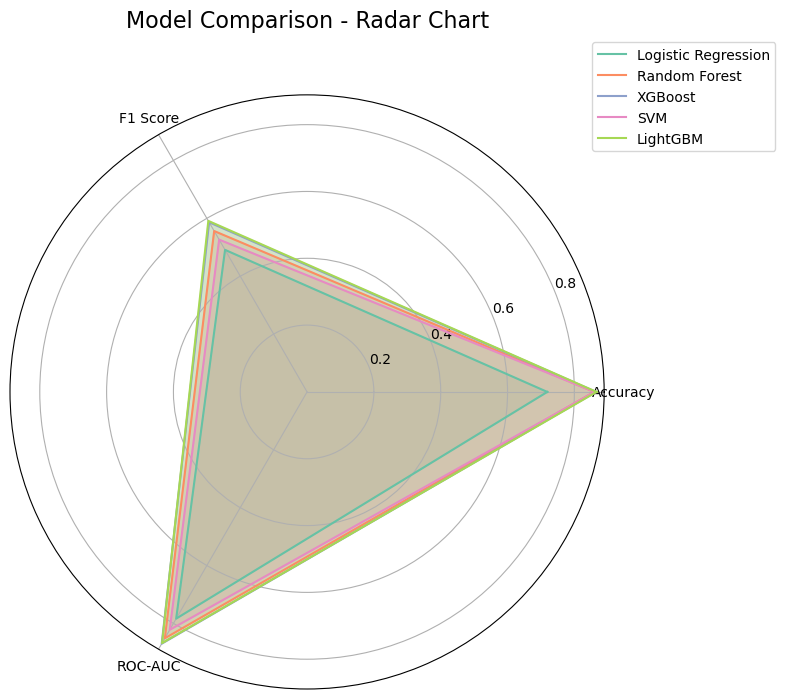

In [14]:
import numpy as np
labels = list(results_df.columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = plt.cm.Set2.colors

for i, (model_name, row) in enumerate(results_df.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=model_name, color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_title("Model Comparison - Radar Chart", size=16, y=1.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"])
ax.grid(True)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

#### ROC Curve Comparison

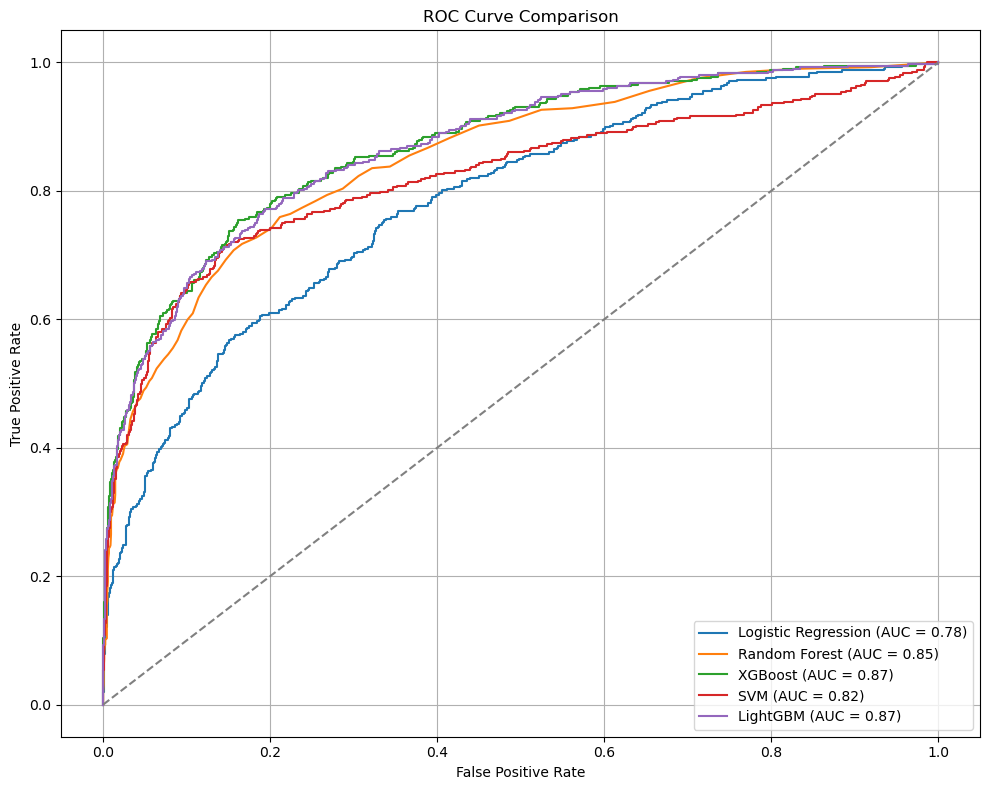

In [15]:
plt.figure(figsize=(10, 8))
for name, (fpr, tpr) in roc_curves.items():
    auc_score = roc_auc_score(y_test, joblib.load(model_paths[name]).predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Precision - Recall Curve Comparison

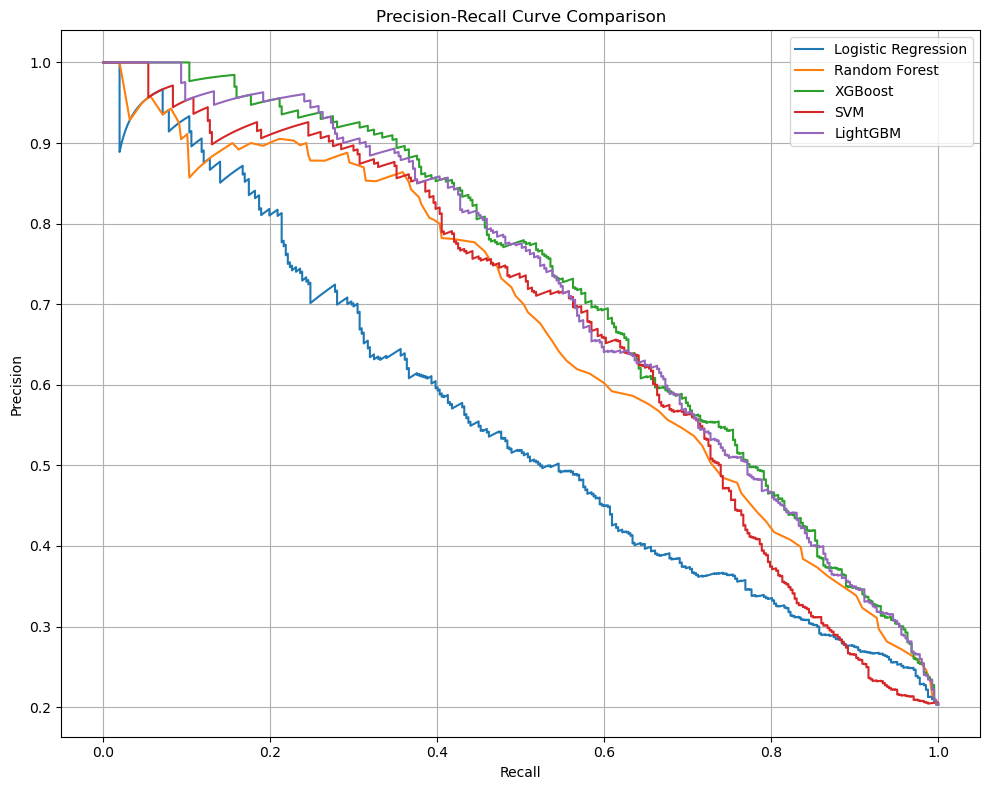

In [16]:
plt.figure(figsize=(10, 8))
for name, (precision, recall) in pr_curves.items():
    plt.plot(recall, precision, label=name)

plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
